In [2]:
pip install z3-solver

Note: you may need to restart the kernel to use updated packages.


In [3]:
from z3 import *
import math
import time
import itertools
import io
from datetime import datetime
import numpy as np


In [7]:
from math import floor


def pack_rectangles(max_width,number_rectangles, width,height,rotation,symmetry):

   #start_time = time.time()
   
    s = Optimize()
    
   
    
    
    
    circuits_x = [Int(f"x_{i}") for i in range(number_rectangles)]
    circuits_y = [Int(f"y_{i}") for i in range(number_rectangles)]
    
    
    
    #s = Solver()
    s.set("timeout", 300 * 1000)
    #x = [Int('x%s' % i) for i in range(number_rectangles)]
    #y = [Int('y%s' % i) for i in range(number_rectangles)]

    R = [Bool('R%s' % i) for i in range(number_rectangles)]

    
    


    
    
    #computing upperbound
    xx=circuits_x.copy()
    yy=circuits_y.copy()  
    #xx=x.copy()
    #yy=y.copy()  
    W =max_width
    upperbound = H_UB (W, dimension_rectangle,xx,yy,False)
    
    Rectangle_height = Int('Rectangle_height')
    s.add(Rectangle_height <= upperbound)
    s.add(Rectangle_height >= lowerbound)
    
    
    
    dx=width
    dy=height
    
    
    # constraint for non overlapping
    for i in range(number_rectangles):
        for j in range(number_rectangles):
            if i != j:
                s.add(Or(
                         And(circuits_x[i] + height[i] <= circuits_x[j], R[i]),
                         And(circuits_x[i] + width[i] <= circuits_x[j], Not(R[i])),
                         And(circuits_x[j] + height[j] <=circuits_x[i], R[j]),
                         And(circuits_x[j] + width[j] <= circuits_x[i], Not(R[j])),
                         And(circuits_y[i] + width[i] <= circuits_y[j], R[i]),
                         And(circuits_y[i] + height[i] <= circuits_y[j], Not(R[i])),
                         And(circuits_y[j] + width[j] <= circuits_y[i], R[j]),     
                         And(circuits_y[j] + height[j] <= circuits_y[i], Not(R[j])),


                         ))

  
    #respecting the maximum boundaries on the x and y axsis 
    s.add([circuits_x[i] >= 0 for i in range(number_rectangles)])
    s.add([Or(Not(R[i]), circuits_x[i] + height[i] - 1 < max_width) for i in range(number_rectangles)])
    s.add([Or(R[i], circuits_x[i] + width[i] - 1 < max_width) for i in range(number_rectangles)])
    
    s.add([circuits_y[i] >= 0 for i in range(number_rectangles)])
    s.add([Or(R[i], circuits_y[i] + height[i] - 1 < Rectangle_height) for i in range(number_rectangles)])
    s.add([Or(Not(R[i]), circuits_y[i] + width[i] - 1 < Rectangle_height) for i in range(number_rectangles)])

    
    
    
    #symmetry breaking bottom left biggest rectagnel 
    areas = np.array(width) * np.array(height)
    i_max = np.argmax(areas) # index of the circuit with the biggest area
    bottom_left_x = [circuits_x[i_max] <= floor((max_width - width[i_max]) / 2  )]
    bottom_left_y = [circuits_y[i_max] <= floor((lowerbound - height[i_max]) / 2 )]
    s.add(Not(R[i_max]))
    s.add(bottom_left_x + bottom_left_y)
    

    '''

      
    circuits_w=width
    circuits_h=height
        

    
    

    

  
        
        
    non_overlap = [Or( 
                    circuits_x[i] + circuits_w[i] <= circuits_x[j],
                    circuits_x[i] >= circuits_x[j] + circuits_w[j],
                    circuits_y[i] + circuits_h[i] <= circuits_y[j],
                    circuits_y[i] >= circuits_y[j] + circuits_h[j]
                    ) for i in range(number_rectangles-1) for j in range(i+1, number_rectangles)]
    
    in_limits = [And(circuits_x[i] + circuits_w[i] <= max_width,
                circuits_y[i] + circuits_h[i] <= Rectangle_height, 
                circuits_x[i] >= 0, 
                circuits_y[i] >= 0) for i in range(number_rectangles)]
    
    
 
    if symmetry:
        # symmetry breaking constraints
        for i in range(number_rectangles):
            for j in range(number_rectangles):
                if i != j:


                    #symmetry breaking constraint         
                    s.add(Implies(circuits_w[i] + circuits_w[j] > W,And(circuits_x[i]+circuits_w[i]>circuits_x[j],circuits_x[j]+circuits_w[j]>circuits_x[i])))
                    s.add(Implies(circuits_h[i] + circuits_h[j] > H,And(circuits_y[i]+circuits_h[i]>circuits_y[j],circuits_y[j]+circuits_h[j]>circuits_y[i])))

    '''
    '''
    #symmetry breaking bottom left biggest rectagnel 
    areas = np.array(width) * np.array(height)
    i_max = np.argmax(areas) # index of the circuit with the biggest area
    bottom_left_x = [circuits_x[i_max] <= floor((max_width - width[i_max]) / 2  )]
    bottom_left_y = [circuits_y[i_max] <= floor((lowerbound - height[i_max]) / 2 )]
    s.add(bottom_left_x + bottom_left_y)

    '''



   
   


       
        
        
        
   # H = lowerbound    
        

    
    
    #s.add(non_overlap + in_limits)
    
    
    

    
    
    
    
    
    

        
        
        
    

    
    
    
    
    
    
    
    
  


                
    
    
    
    
    s.minimize(Rectangle_height)

    if s.check() == sat:
        print('Solved')
        print(s.statistics().time)
    else:
        print('UNSAT')
        return -1,-1,-1,-1,301

    #return s,circuits_x,circuits_y, R,s.statistics().time
    return s,x,y,R,s.statistics().time


def H_UB( W, rectangles,x,y, plot=False):
    placer_x = 0
    occupied_height= [0]*W
    
    q=0
    for r in rectangles:
        occupied_height_copy = occupied_height.copy()
        placer_x = np.argmin(occupied_height_copy)
        placer_y = min(occupied_height_copy)
        while ((placer_x + r[0])>W or any([x > placer_y for x in occupied_height[placer_x:(placer_x + r[0])]])):
            occupied_height_copy.remove(placer_y)
            placer_x = np.argmin(occupied_height_copy)
            placer_y = min(occupied_height_copy)

       
        x[q] = placer_x
        y[q] = placer_y
        
        for i in range(placer_x, placer_x + r[0]):
            occupied_height[i] = placer_y + r[1]
        
        q=q+1
        placer_x += r[0]
        
    
    if plot:
        plot_rectangles(rectangles, title = self.name)
        
    list_a=[]
    Z=0
    for r in rectangles:
        list_a.append(r[1]+y[Z])
        Z=Z+1
        
    return max(list_a)

for i in range(1,41):
    file_name = "./../instances/ins-" + str(i) + ".txt"
    file = open(file_name)
    max_width = int(file.readline())
    number_rectangles = int(file.readline())

    width = []
    height = []

    for line in file:
        width_height = line.split()
        width_height = [int(x) for x in width_height]
        width.append(width_height[0])
        height.append(width_height[1])

    dimension_rectangle = []
    for j, k in zip(width, height):
        dimension_rectangle.append([j, k])

    area = sum([b[0] * b[1] for b in dimension_rectangle])
    lowerbound = area / max_width
    circuits_w,circuits_h=width,height
    

    start = time.time()
    s, px, py, R, time_x = pack_rectangles(max_width,number_rectangles,width,height,True, False)
    end = time.time()
    
    final_time = end - start

    if s != -1:
        m = s.model()
        file_out = "./../out_2_test_r/out-" + str(i) + ".txt"
        file_out_time_1 = "./../time_2_test_r/time-" + str(i) + ".txt"

        with open(file_out, 'w') as file:

            result = sorted([(d, m[d]) for d in m], key=lambda x: str(x[0]))
            file.write(str(max_width) + ' ' + str(lowerbound) + "\n")
            file.write(str(number_rectangles)+'\n')
            for k in range(1,number_rectangles+1):
                file.write(str(width[k-1]) + ' ' + str(height[k-1]) + ' ' + str(m.evaluate(px[k-1])) + ' ' + str(m.evaluate(py[k-1])) +' ' + str(m.evaluate(R[k-1]))+ "\n")


        with open(file_out_time_1, 'w') as file:
            file.write(str(final_time))
             
    else:
        
        file_out_time_1 = "./../time_2_test_r_UN/time-" + str(i) + ".txt"
        
        with open(file_out_time_1, 'w') as file:
            
            file.write(str(final_time))
    
         

Solved
0.003
Solved
0.005
Solved
0.01
Solved
0.018
Solved
0.02
Solved
0.031
Solved
0.179
Solved
0.119
Solved
0.699
Solved
1.155
Solved
28.42
Solved
6.281
Solved
0.948
Solved
35.628
Solved
8.876
Solved
39.872
Solved
142.627
UNSAT
UNSAT
UNSAT
UNSAT
UNSAT
UNSAT
Solved
11.223
UNSAT
UNSAT
Solved
32.646
Solved
48.893
UNSAT
UNSAT
Solved
51.937
UNSAT
Solved
10.792
Solved
252.356
Solved
12.31
Solved
17.923
UNSAT
UNSAT
UNSAT
UNSAT


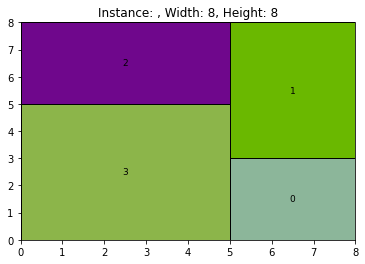

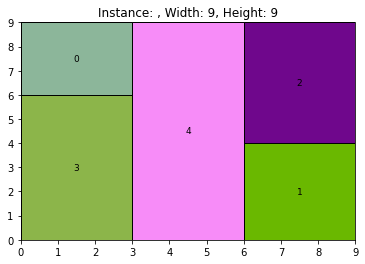

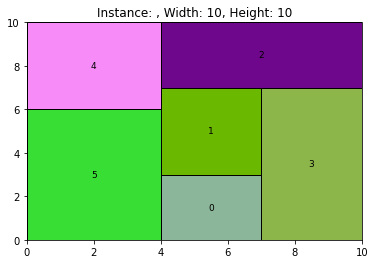

ValueError: invalid literal for int() with base 10: 'False'

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
import numpy as np


class Rectangle:
  '''
  Implementation of a Rectangle structure

  x: the x coordinate of the LEFT BOTTOM corner
  y: the y coordinate of the LEFT BOTTOM corner
  width: the width of the rectangles
  height: the weight of the rectangles 
  '''
  def __init__ (self, width, height, x=None, y=None):
    self.x = x
    self.y = y
    self.width = width
    self.height = height
    #self.rotation=rotation

def plot_rectangles(rectangles, title="", indexes=True):
  '''
  This function plots the given input rectangles and computes the placing margins of those
  
  rectangles: the rectangles to be plotted
  title: the title to be assigned to the plot
  indexes: True to plot the indexes of the input rectangles, ordered by list index
'''

  title = re.split("/", title)
  title = title[-1].replace(".txt","")

  fig, ax = plt.subplots()

  max_height = max([rectangles[i].y + rectangles[i].height] for i in range(len(rectangles)))[0]
  max_width = max([rectangles[i].x + rectangles[i].width] for i in range(len(rectangles)))[0]

  for i in range(0,len(rectangles)):
    np.random.seed(i)
    rect_draw = patches.Rectangle( (rectangles[i].x, rectangles[i].y) , rectangles[i].width , rectangles[i].height, facecolor = np.random.rand(3,), edgecolor='k', label="ciao")
    ax.add_patch(rect_draw)

    if indexes:
      cx = rectangles[i].x + rectangles[i].width/2.0
      cy = rectangles[i].y + rectangles[i].height/2.0
      ax.annotate(i, (cx, cy), color='k', 
                  fontsize=9, ha='center', va='center')

  ax.set_title("Instance: {}, Width: {}, Height: {}".format(title, max_width, max_height))
  ax.spines['top'].set_visible(False)
  ax.set_xlim((0, max_width))
  ax.set_ylim((0, max_height))
  #ax.set_aspect('equal')
  ax.autoscale_view(tight=True)
  ax.set_axisbelow(True)
  ax.grid()
  plt.show()



#ploting instance number 36 as an example 
for i in range(1,5):
    instance=i
    file_name = "./../out_2_test_r/out-" + str(instance) + ".txt"
    file_out = open(file_name)
    results= file_out.readlines()

    list =[]

    for coordinates in results[2:]:
        w_h_x_y_r = coordinates.split()
        w_h_x_y_r = [int(x) for x in w_h_x_y_r]
        w= w_h_x_y_r[0]
        h= w_h_x_y_r[1]
        x= w_h_x_y_r[2]
        y= w_h_x_y_r[3]
      #  r= w_h_x_y_r[4]
        
        list.append(Rectangle (w,h,x,y))
        
    

    plot_rectangles(list)